In [1]:
# Some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
import ast
import re
import src.scripts.regression_fct as reg
import statsmodels.api as sm



In [2]:
# Load the general data:
success_movies_path = 'data/processed_data/success_movies.csv'

success_movies_all = pd.read_csv(success_movies_path, sep=',')
success_movies_df =success_movies_all.dropna(subset=['diversity'])

success_movies_df= success_movies_df[success_movies_df["actor_number"] != 1]


## Regression


In [14]:
reg_results_df,model = reg.regression(success_movies_df, ['diversity'], 'Success')
# reg_results_df['y_pred'] = reg_results_df['y_pred'].apply(lambda x: 1 if x > 0.5 else 0)
# reg.plot_results(reg_results_df, reg_results_df['X_test'],'diversity', 'Success')
plt.figure(figsize=(10, 6))
# plt.bar(reg_results_df['X_test'], reg_results_df['y_test'], color='blue', alpha=0.5, label='Actual')
display(reg_results_df['y_pred'].describe())
# sns.barplot(
#     x=reg_results_df['diverstiy'],
#     y=reg_results_df['y_pred'],
#     color='red',
#     alpha=0.5,
#     label='Predicted'
# )

display(model.summary())

<class 'pandas.core.frame.DataFrame'>


count    2768.000000
mean        0.110399
std         0.013699
min         0.060716
25%         0.100156
50%         0.113608
75%         0.122065
max         0.126347
Name: y_pred, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Success   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     21.14
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           4.32e-06
Time:                        15:46:08   Log-Likelihood:                -2867.9
No. Observations:               11069   AIC:                             5740.
Df Residuals:                   11067   BIC:                             5754.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1108      0.003     37.163      0.000       0.105       0.117
diversity     -0.0137      0.003     -4.598      0.000      -0.020      -0.008
==============================================================================
Omnibus:                     5164.408   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19178.983
Skew:                           2.473   Prob(JB):                         0.00
Kurtosis:                       7.137   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 1000x600 with 0 Axes>

In [4]:
from sklearn.model_selection import train_test_split
# split the data into train and test sets using a 80-20 split
train, test = train_test_split(success_movies_df, test_size=0.2, random_state=42)

# print number of samples in the training and test sets
print(f"The number of samples in the training set is: {train.shape[0]}")
print(f"The number of samples in the test set is: {test.shape[0]}")

The number of samples in the training set is: 11069
The number of samples in the test set is: 2768


In [5]:
# split the data into features and target for the train and test datasets. 
# features contains all the columns minus the column price and label contains only the column price. 
# We will use this to train our model and then test it on the test set.
# Training features and target
features = ['Ratings', 'Nomination'] # 'Movie_box_office_revenue',
X_train = train[features]
y_train = train['diversity']

# testing features and target
X_test = test[features]
y_test = test['diversity']

# describe the training target variable
X_test.head()




,Ratings,Nomination
17743,8.0,False
15963,6.9,False
10800,3.6,False
7250,6.6,False
2331,7.8,True


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# we add constant column
X_train_scaled = sm.add_constant(X_train_scaled)

# we print the mean and standard deviation of the training set after standardization
print(f"The mean of the training set after standardization is:\n{X_train_scaled.mean()}")
print(f"The standard deviation of the training set after standardization:\n{X_train_scaled.std()}")

The mean of the training set after standardization is:
const         1.000000e+00
Ratings       7.073973e-16
Nomination   -2.599781e-17
dtype: float64
The standard deviation of the training set after standardization:
const         0.000000
Ratings       1.000045
Nomination    1.000045
dtype: float64


In [7]:
# train a linear regression model on the training dataset
model = sm.OLS(y_train, X_train_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              diversity   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     23.35
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           7.62e-11
Time:                        15:08:46   Log-Likelihood:                -7653.7
No. Observations:               11069   AIC:                         1.531e+04
Df Residuals:                   11066   BIC:                         1.534e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5759      0.005    125.398      0.0

RMSE values for different regression models are as follows:

In [8]:
from sklearn.metrics import mean_squared_error

# standardize the test features 
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)
X_test_scaled = sm.add_constant(X_test_scaled)

# make predictions on the test dataset
y_pred = model.predict(X_test_scaled)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} ")

RMSE: 0.50 


In [9]:
# Get the p-values from the model summary
p_values = model.pvalues
display(p_values)
# Display features with p-values < 0.05
significant_features = p_values[p_values < 0.05]
print("Statistically significant features (p-value < 0.05):")
print(significant_features)

const         0.000000e+00
Ratings       5.147793e-04
Nomination    2.624945e-11
dtype: float64

Statistically significant features (p-value < 0.05):
const         0.000000e+00
Ratings       5.147793e-04
Nomination    2.624945e-11
dtype: float64


In [10]:
# get the models coefficients
coefficients = model.params

# we sort these coefficients 
sorted_coefficients = coefficients.abs().sort_values(ascending=False)

# we keep the two features with the highest coef
top_2_features = sorted_coefficients.head(3)
print(top_2_features)

const         0.575906
Nomination    0.032247
Ratings       0.016788
dtype: float64


#### Violin plots

<Axes: xlabel='Nomination', ylabel='diversity'>

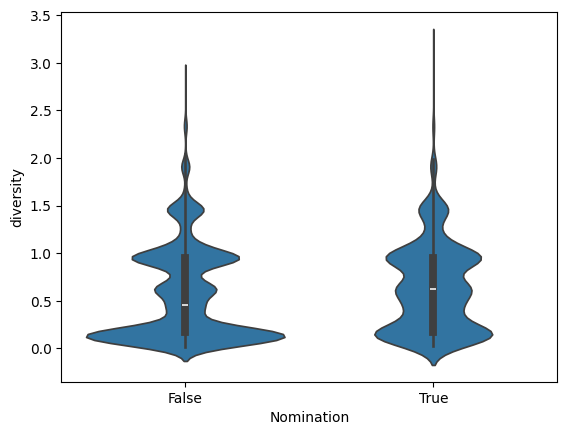

In [ ]:
sns.violinplot(data=success_movies_df, x="Nomination", y="diversity") #, hue="diversity")

Does diversity can predict success? 

In [ ]:
feature = ['diversity']
X_train = train[feature]
y_train = train['Success']

# testing features and target
X_test = test[feature]
y_test = test['Success']

# standardize the training features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# we add constant column
X_train_scaled = sm.add_constant(X_train_scaled)

# we print the mean and standard deviation of the training set after standardization
print(f"The mean of the training set after standardization is:\n{X_train_scaled.mean()}")
print(f"The standard deviation of the training set after standardization:\n{X_train_scaled.std()}")

# standardize the test features
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_scaled = sm.add_constant(X_test_scaled)

# train a linear regression model on the training dataset
model = sm.OLS(y_train, X_train_scaled).fit()
print(model.summary())
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.apply(lambda x: 1 if x > 0.5 else 0)

The mean of the training set after standardization is:
const        1.000000e+00
diversity   -1.821452e-16
dtype: float64
The standard deviation of the training set after standardization:
const        0.000000
diversity    1.000045
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                Success   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     21.14
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           4.32e-06
Time:                        15:08:46   Log-Likelihood:                -2867.9
No. Observations:               11069   AIC:                             5740.
Df Residuals:                   11067   BIC:                             5754.
Df Model:                           1                                         
Covariance Type:            nonrobust     

--> The correlation between diversity and success is not strong.

In [13]:
success_movies_df['ratings_quartile'] = pd.qcut(success_movies_df['Ratings'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
success_movies_df['box_office_quartile'] = pd.qcut(success_movies_df['Movie_box_office_revenue'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

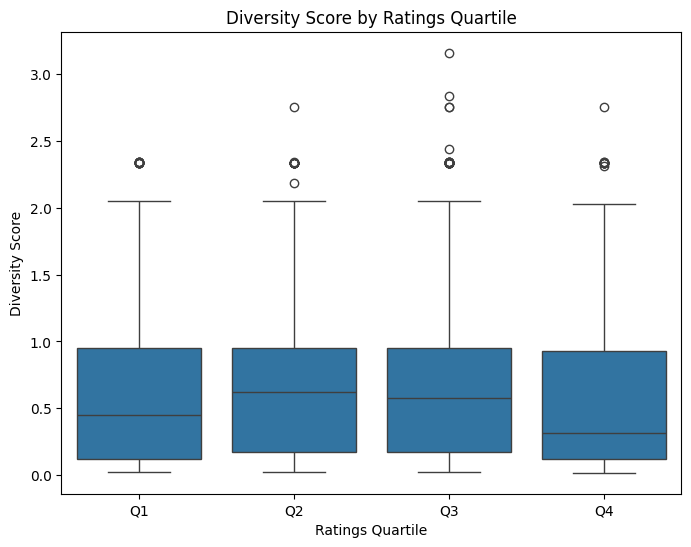

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='ratings_quartile', y='diversity', data=success_movies_df)
plt.title('Diversity Score by Ratings Quartile')
plt.xlabel('Ratings Quartile')
plt.ylabel('Diversity Score')
plt.show()


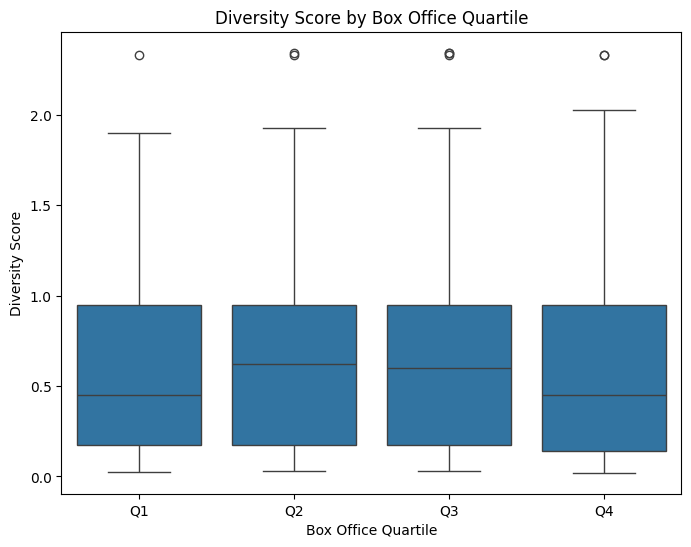

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='box_office_quartile', y='diversity', data=success_movies_df)
plt.title('Diversity Score by Box Office Quartile')
plt.xlabel('Box Office Quartile')
plt.ylabel('Diversity Score')
plt.show()


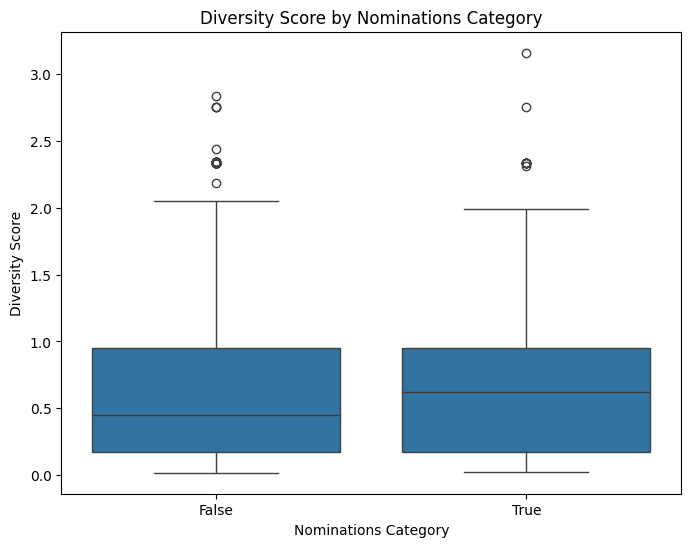

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Nomination', y='diversity', data=success_movies_df)
plt.title('Diversity Score by Nominations Category')
plt.xlabel('Nominations Category')
plt.ylabel('Diversity Score')
plt.show()

Diversity quartile observation per success metrics 

In [17]:
success_movies_df['diversity_quartile'] = pd.qcut(success_movies_df['diversity'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])


Ratings per diversity quartile

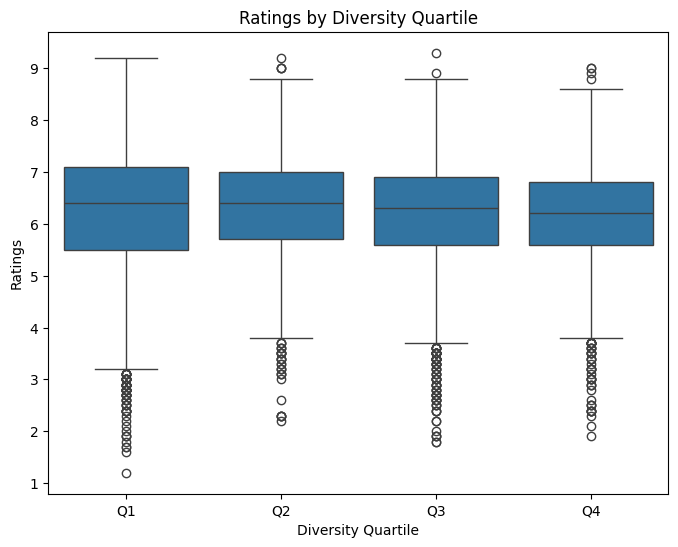

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='diversity_quartile', y='Ratings', data=success_movies_df)
plt.title('Ratings by Diversity Quartile')
plt.xlabel('Diversity Quartile')
plt.ylabel('Ratings')
plt.show()

Box office per diversity quartile

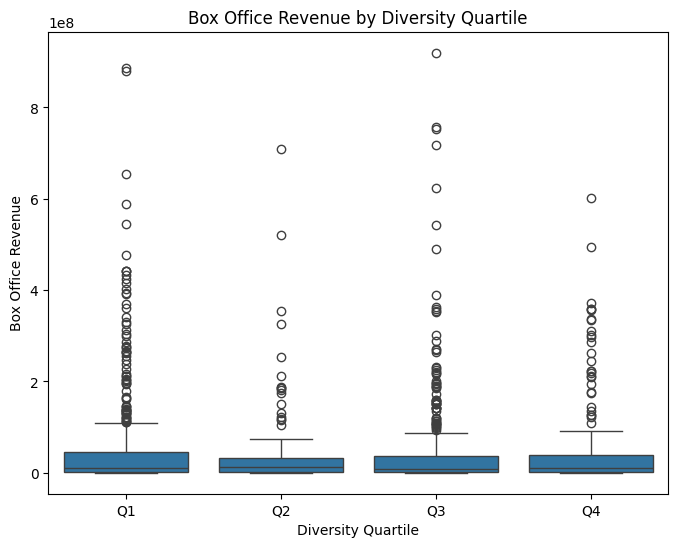

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='diversity_quartile', y='Movie_box_office_revenue', data=success_movies_df)
plt.title('Box Office Revenue by Diversity Quartile')
plt.xlabel('Diversity Quartile')
plt.ylabel('Box Office Revenue')
plt.show()


C:\Users\franc\AppData\Local\Temp\ipykernel_21064\2795874012.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nomination_rate = success_movies_df.groupby('diversity_quartile')['Nomination'].mean().reset_index()


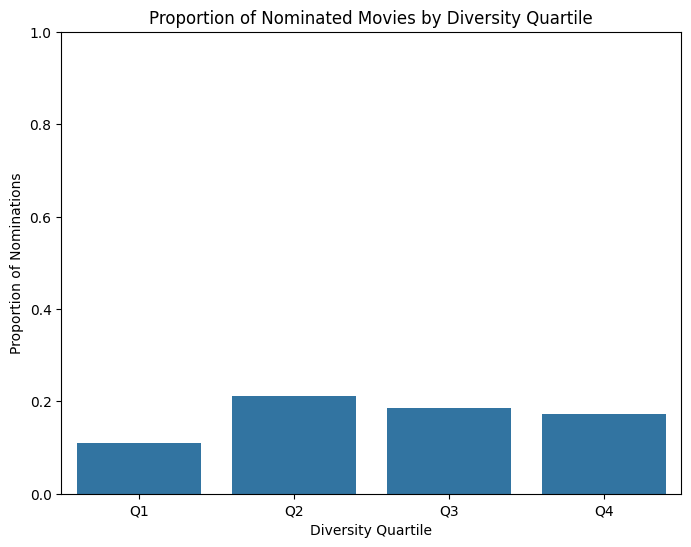

In [20]:
# Calculate the nomination rate per diversity quartile
nomination_rate = success_movies_df.groupby('diversity_quartile')['Nomination'].mean().reset_index()

# Barplot for nomination rate
plt.figure(figsize=(8, 6))
sns.barplot(x='diversity_quartile', y='Nomination', data=nomination_rate)
plt.title('Proportion of Nominated Movies by Diversity Quartile')
plt.xlabel('Diversity Quartile')
plt.ylabel('Proportion of Nominations')
plt.ylim(0, 1)
plt.show()
